In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from jenks import jenks
from datetime import datetime
import numpy as np
import dask.dataframe as dd

## Dataset Preparation

In [2]:
# read dataset
path = '../dataset/data13to17Feb2018.csv'
df = pd.read_csv(path, usecols=['Time', 'Source', 'Destination', 'Protocol', 'Length']).dropna()

# keep only the columns that we want
df = df[['Time', 'Length']]

# transform time column to datetime object
df['Time']= pd.to_datetime(df['Time'])

In [3]:
# we want to disregard the records which have as date 1970
df['Year'] = df['Time'].dt.year
df = df[df['Year'] > 1970]
df = df[['Time', 'Length']]

In [4]:
# check how the dataset looks like
df.head()

,Time,Length
0,2019-02-13 02:13:38.346809,152
1,2019-02-13 02:13:38.347297,40
2,2019-02-13 02:13:38.678841,88
3,2019-02-13 02:13:38.679018,40
4,2019-02-13 02:16:38.390502,152


## Get a slice of the whole dataset

In [5]:
# sliced_df = df[(df['Time'].dt.day == 13) & (df['Time'].dt.hour > 14) & (df['Time'].dt.hour < 16)]
# sliced_df = sliced_df.iloc[800:10800]

In [6]:
sliced_df = df[0:100000]

#### Plot the sliced dataset

/home/vaggelis/.local/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  fig.canvas.print_figure(bytes_io, **kw)


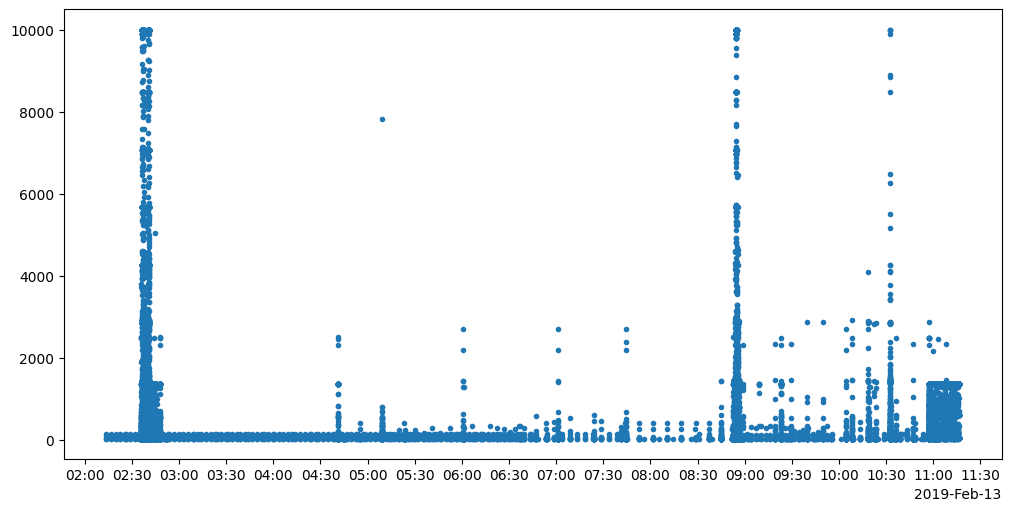

In [7]:
x = sliced_df['Time']
y = sliced_df['Length']

fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 5))
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

axs.plot(x, y, alpha = 1, linestyle = '-', linewidth = 0, marker = 'o', markersize = 3)

plt.title('')

plt.show()

## Find ideal number of clusters

In [8]:
# function to help up assign clusters
def put_to_cluster(value, cluster_limits):
    cluster_index = 0
    for i in range(len(cluster_limits)):
        upper = cluster_limits[i]
        if value <= upper:
            return cluster_index
        cluster_index += 1

In [9]:
def goodness_of_variance_fit(array, classes):
    # get the break points
    classes = jenks(array, classes)

    # do the actual classification
    classified = np.array([put_to_cluster(i, classes) for i in array])

    # max value of zones
    maxz = max(classified)

    # nested list of zone indices
    zone_indices = [[idx for idx, val in enumerate(classified) if zone + 1 == val] for zone in range(maxz)]

    # sum of squared deviations from array mean
    sdam = np.sum((array - array.mean()) ** 2)

    # sorted polygon stats
    array_sort = [np.array([array[index] for index in zone]) for zone in zone_indices]

    # sum of squared deviations of class means
    sdcm = sum([np.sum((classified - classified.mean()) ** 2) for classified in array_sort])

    # goodness of variance fit
    gvf = (sdam - sdcm) / sdam

    return gvf

In [10]:
gvf = 0.0
nclasses = 2
X = sliced_df['Length'].to_numpy()
while gvf < 0.90:
    print('Current gvf: ', gvf, ' nclasses: ', nclasses)
    gvf = goodness_of_variance_fit(X, nclasses)
    nclasses += 1

Current gvf:  0.0  nclasses:  2
Current gvf:  0.6077241891588177  nclasses:  3
Current gvf:  0.8683632845263306  nclasses:  4


## Clustering of the initial dataset

#### Calculate the cluster limits based on the jenks method

In [11]:
cluster_limits = jenks(y, nclasses)

In [12]:
# assign records of the sliced dataset in clusters
sliced_df['Bucket'] = sliced_df['Length'].apply(lambda x: put_to_cluster(x, cluster_limits))

/tmp/ipykernel_209/1414041247.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sliced_df['Bucket'] = sliced_df['Length'].apply(lambda x: put_to_cluster(x, cluster_limits))


#### Plot the sliced dataset with the clusters

/home/vaggelis/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:744: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  labels = axis.get_majorticklabels() + axis.get_minorticklabels()
/home/vaggelis/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/tools.py:55: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  for label in ax.get_xticklabels():
/home/vaggelis/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:744: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  labels = 

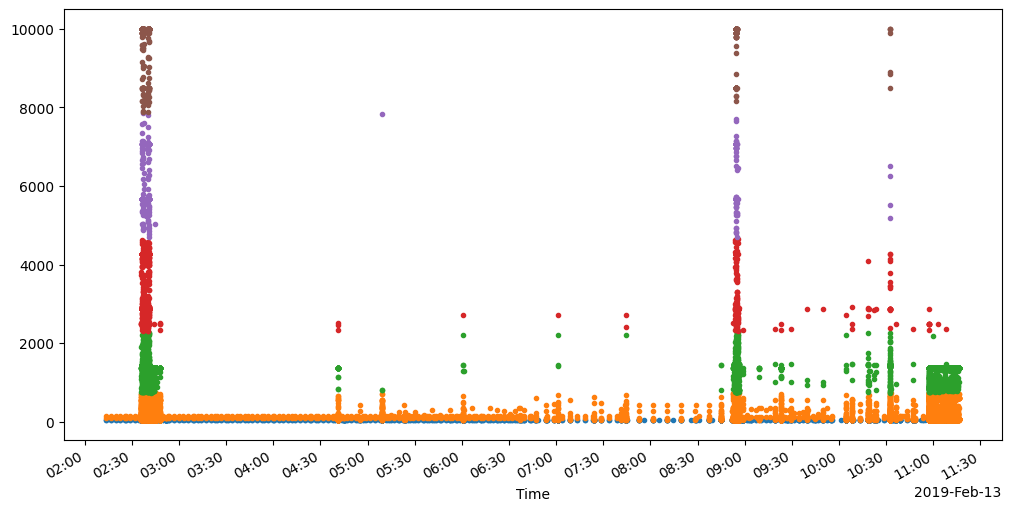

In [13]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 5))
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

sliced_df.reset_index().groupby('Bucket').plot(x='Time', y='Length', ax=axs, alpha = 1, linestyle = '-', linewidth = 0, marker = 'o', markersize = 3)

axs.get_legend().remove()

plt.show()

## Concise sampling

In [14]:
# prepare the dataset for sampling
event_list = []
for index, row in sliced_df.iterrows():
    event_list.append(str(index) + ',' + str(row['Time']) + ',' + str(row['Length']))

In [15]:
def concise_sampling(event):
    N = len(event)
    a = 1.1 # We increase T by 10%
    max_size = N / 10

    # 1/T = selection probability
    T = 1

    #// S = Concise Sample
    S = {}
    S_help = {}
    S_help_real_index = {}
    len_S = 0

    for ev in event:
        
        real_idx, idx, val = ev.split(",")
        
        t_real_idx = int(real_idx)
        t_idx = datetime.strptime(idx, '%Y-%m-%d %H:%M:%S.%f')
        t_val = float(val)

        if np.random.random() < 1/T:
            if t_val in S:
                S[t_val] += 1
                S_help[t_val].append(t_idx)
                S_help_real_index[t_val].append(t_real_idx)
            else:
                S_help[t_val] = [t_idx]
                S_help_real_index[t_val] = [t_real_idx]
                S[t_val] = 1
            len_S += 1

    
        # Deletion step, Adjust sample when it gets too large
        
        if len_S> max_size:
            T_prime = a * T
            
            for s in S:
                for _ in range(S[s]):
                    if np.random.random() < 1 - T/T_prime:
                        S[s] -= 1
                        len_S -=1
                        if len(S_help[s]) == 1:
                            S_help[s].pop(0)
                            S_help_real_index[s].pop(0)
                        else:
                            rnd_metric = np.random.randint(0,len(S_help[s])-1)
                            S_help[s].pop(rnd_metric)
                            S_help_real_index[s].pop(rnd_metric)
            
            T = T_prime
    
    real_idx_list = []
    idx_list = []
    res_list = []

    for s in S:
        if S[s] > 0:
            for i in range(S[s]):
                idx_list.append(S_help[s][i])
                real_idx_list.append(S_help_real_index[s][i])
                res_list.append(s)

    return idx_list, res_list, real_idx_list

In [16]:
idx_list, res_list, real_idx_list = concise_sampling(event_list)

## Sampled Dataset

#### Plot without clusters

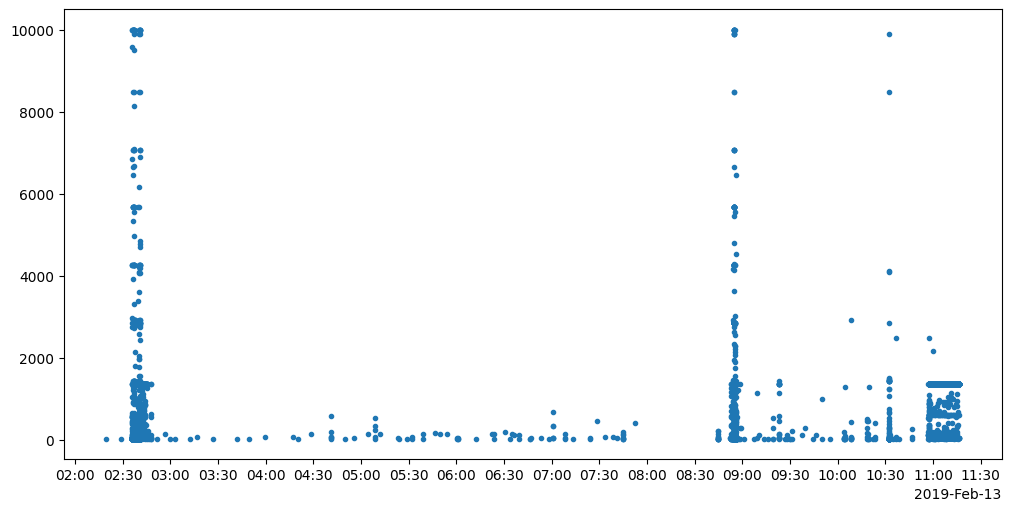

In [17]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 5))
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

axs.plot(idx_list, res_list, alpha = 1, linestyle = '-', linewidth = 0, marker = 'o', markersize = 3)

plt.show()

### Add the information for the initial clusters C

In [18]:
# create a dataframe of the sliced dataset
sampled_df = pd.DataFrame({'Time':idx_list, 'Length':res_list}, index=real_idx_list)

In [19]:
sampled_with_sliced_df = sampled_df.merge(sliced_df, how = 'left', left_index=True, right_index=True)
sampled_with_sliced_df = sampled_with_sliced_df[['Time_x','Length_x', 'Bucket']]
sampled_with_sliced_df.columns = ['Time', 'Length', 'C_cluster']

In [20]:
sampled_with_sliced_df.head()

,Time,Length,C_cluster
44414,2019-02-13 02:56:48.361857,152.0,1
44562,2019-02-13 04:28:38.350183,152.0,1
44771,2019-02-13 05:04:38.424642,152.0,1
44879,2019-02-13 05:12:00.234536,152.0,1
44963,2019-02-13 05:39:00.446717,152.0,1


/home/vaggelis/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:744: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  labels = axis.get_majorticklabels() + axis.get_minorticklabels()
/home/vaggelis/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/tools.py:55: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  for label in ax.get_xticklabels():
/home/vaggelis/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:744: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  labels = 

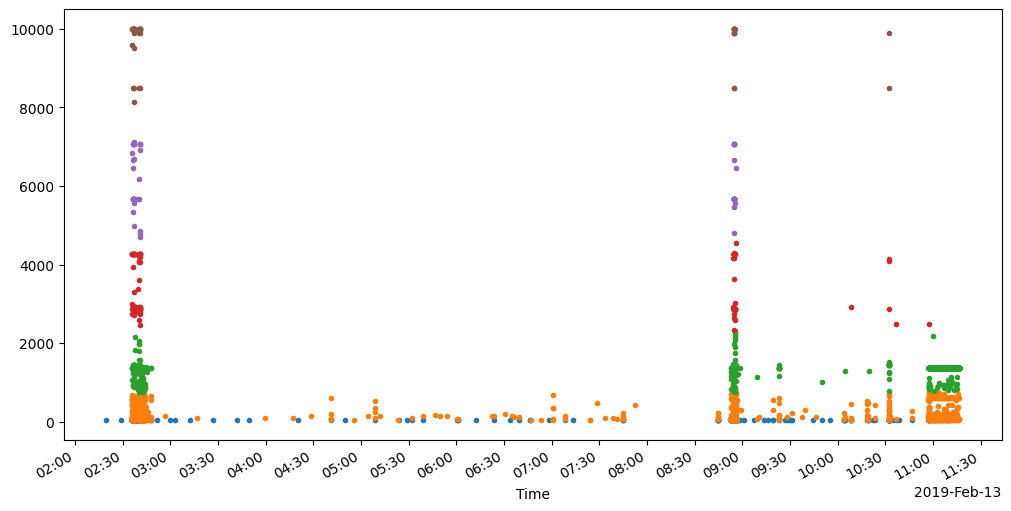

In [21]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 5))
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

sampled_with_sliced_df.reset_index().groupby('C_cluster').plot(x='Time', y='Length', ax=axs, alpha = 1, linestyle = '-', linewidth = 0, marker = 'o', markersize = 3)

axs.get_legend().remove()

plt.show()

### Prodcuce the new clusters C'

In [22]:
# produce the cluster limits for the sliced dataset
cluster_limits = jenks(res_list, nclasses)

# apply the new clusters in the sliced dataset
sampled_with_sliced_df['C_prime_cluster'] = sampled_with_sliced_df['Length'].apply(lambda x: put_to_cluster(x, cluster_limits))

In [23]:
# check the sampled dataset
sampled_with_sliced_df.head()

,Time,Length,C_cluster,C_prime_cluster
44414,2019-02-13 02:56:48.361857,152.0,1,1
44562,2019-02-13 04:28:38.350183,152.0,1,1
44771,2019-02-13 05:04:38.424642,152.0,1,1
44879,2019-02-13 05:12:00.234536,152.0,1,1
44963,2019-02-13 05:39:00.446717,152.0,1,1


## Plot the new clustering C' in the sliced dataset

/home/vaggelis/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:744: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  labels = axis.get_majorticklabels() + axis.get_minorticklabels()
/home/vaggelis/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/tools.py:55: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  for label in ax.get_xticklabels():
/home/vaggelis/.local/lib/python3.10/site-packages/pandas/plotting/_matplotlib/core.py:744: UserWarning: AutoDateLocator was unable to pick an appropriate interval for this date range. It may be necessary to add an interval value to the AutoDateLocator's intervald dictionary. Defaulting to 30.
  labels = 

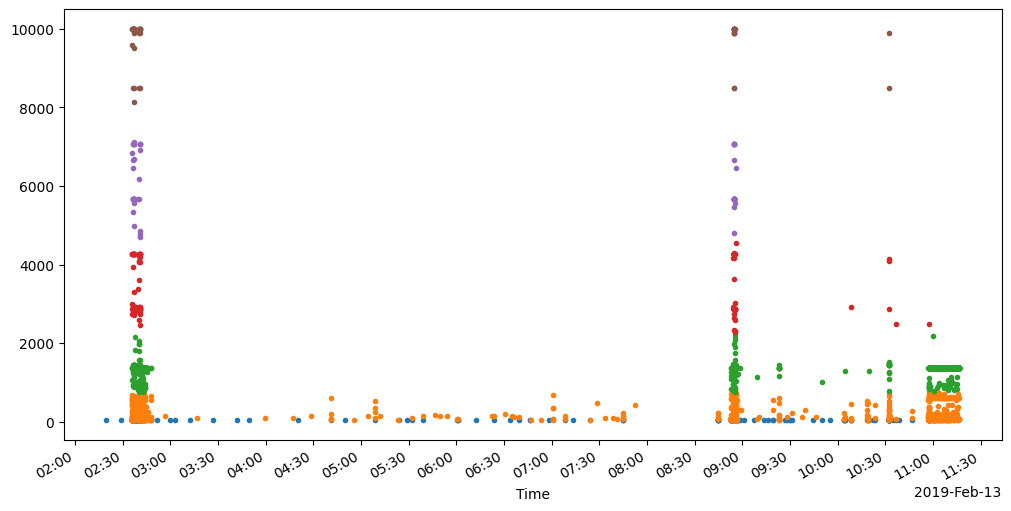

In [24]:
fig, axs = plt.subplots(1, 1, constrained_layout=True, figsize=(10, 5))
locator = mdates.AutoDateLocator(minticks=10, maxticks=20)
formatter = mdates.ConciseDateFormatter(locator)
axs.xaxis.set_major_locator(locator)
axs.xaxis.set_major_formatter(formatter)

sampled_with_sliced_df.reset_index().groupby('C_prime_cluster').plot(x='Time', y='Length', ax=axs, alpha = 1, linestyle = '-', linewidth = 0, marker = 'o', markersize = 3)

axs.get_legend().remove()

plt.show()

# Cluster Validation

S11 = pairs that are in the same cluster under C and C’

S00 = pairs that are in different clusters under C and C’

S10 = pairs that are in the same cluster under C but in different ones under C’

S01 = pairs that are in different clusters under C but in the same under C’

In [26]:
sampled_with_sliced_df.head()

,Time,Length,C_cluster,C_prime_cluster
44414,2019-02-13 02:56:48.361857,152.0,1,1
44562,2019-02-13 04:28:38.350183,152.0,1,1
44771,2019-02-13 05:04:38.424642,152.0,1,1
44879,2019-02-13 05:12:00.234536,152.0,1,1
44963,2019-02-13 05:39:00.446717,152.0,1,1


In [27]:
sampled_with_sliced_df['key1'] = 0
sampled_with_sliced_df['key2'] = 0
sampled_with_sliced_df['index'] = sampled_with_sliced_df.index

In [ ]:
cross_joined_df = dd.merge(sampled_with_sliced_df, sampled_with_sliced_df, left_on='key1', right_on='key2', how='outer')


In [ ]:
cross_joined_df = sampled_with_sliced_df.merge(sampled_with_sliced_df, left_on='key1', right_on='key2', how='outer')
cross_joined_df = cross_joined_df[['index_x', 'index_y', 'C_cluster_x', 'C_prime_cluster_x', 'C_cluster_y', 'C_prime_cluster_y']]
cross_joined_df = cross_joined_df[cross_joined_df['index_x'] != cross_joined_df['index_y']]

In [ ]:
cross_joined_df.head()

In [ ]:
n11 = len(cross_joined_df[(cross_joined_df['C_cluster_x'] == cross_joined_df['C_cluster_y']) \
                      & (cross_joined_df['C_prime_cluster_x'] == cross_joined_df['C_prime_cluster_y'])]) / 2

n00 = len(cross_joined_df[(cross_joined_df['C_cluster_x'] != cross_joined_df['C_cluster_y']) \
                      & (cross_joined_df['C_prime_cluster_x'] != cross_joined_df['C_prime_cluster_y'])]) / 2

n10 = len(cross_joined_df[(cross_joined_df['C_cluster_x'] == cross_joined_df['C_cluster_y']) \
                      & (cross_joined_df['C_prime_cluster_x'] != cross_joined_df['C_prime_cluster_y'])]) / 2

n01 = len(cross_joined_df[(cross_joined_df['C_cluster_x'] != cross_joined_df['C_cluster_y']) \
                      & (cross_joined_df['C_prime_cluster_x'] == cross_joined_df['C_prime_cluster_y'])]) / 2

n = len(sampled_with_sliced_df)

### Rand Index

In [ ]:
rand_index = (2 * (n11 + n00)) / (n * (n - 1))
rand_index

### Fowlkes–Mallows Index

In [ ]:
fm_index = n11 / np.sqrt((n11+n10)*(n11+n01))
fm_index

### Mirkin Metric

In [ ]:
mirkin_mettric = n*(n-1)*(1-rand_index)
mirkin_mettric

### Jaccard Index

In [ ]:
jaccard_index = n11 / (n11 + n10 + n01)
jaccard_index